In [1]:
import pandas as pd
import numpy as np
# from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 전처리 과정

In [16]:
user_list = pd.read_csv('data/user_list_GH2.csv')
train = pd.read_csv('data/train.csv')

In [17]:
# 필요없는 칼럼을 삭제합니다.
user_list.drop(columns=['Unnamed: 0' ], inplace=True)
# family_size와 관련성이 매우 높으므로 삭제합니다. (다중공선성 문제 우려)
user_list.drop(columns=['child_num'], inplace=True)

In [18]:
# 결측치 분석을 위해 미리 fillna를 시행합니다.
user_list['occyp_type'].fillna('Nan', inplace=True)

In [19]:
# 나이 값을 제대로 표시하기 위한 작업
# DAYS_BIRTH 0 혹은 양수값이 없음 확인 및 절대값 처리 후 365 나눠 age 칼럼 생성 (만 나이로 처리하기 위해 //를 사용)
user_list['age'] = user_list['DAYS_BIRTH'].abs()//365
user_list['age_month'] = (user_list['DAYS_BIRTH'].abs()%365)//30
user_list['age_month_total'] = user_list['age'] + round(user_list['age_month'] * (1/12), 2)

In [20]:
# 근무일자를 제대로 표시하기 위한 작업
# 워킹일자 0보다 큰 값은 무효값으로 양수 전부 0으로 처리 후 work_year 칼럼 생성
len(user_list[user_list['DAYS_EMPLOYED']>=0])
user_list['DAYS_EMPLOYED'].sort_values().value_counts()
user_list['DAYS_EMPLOYED'] = user_list['DAYS_EMPLOYED'].replace(365243, 0)

user_list.query('DAYS_EMPLOYED < 0')['DAYS_EMPLOYED'].sort_values()

#워킹일자 0보다 큰 값은 무효값으로 양수 전부 0으로 처리 후 work_year 칼럼 생성
user_list['DAYS_EMPLOYED'].sort_values().value_counts()
user_list['DAYS_EMPLOYED'] = user_list['DAYS_EMPLOYED'].replace(365243, 0)
user_list.query('DAYS_EMPLOYED < 0')['DAYS_EMPLOYED'].sort_values()
user_list['work_year'] = user_list['DAYS_EMPLOYED'].abs()/365
user_list['work_year'] = user_list['work_year'].round()
user_list['work_year'].value_counts().sort_index()

0.0     1767
1.0      890
2.0      764
3.0      750
4.0      655
5.0      579
6.0      467
7.0      422
8.0      379
9.0      317
10.0     281
11.0     201
12.0     169
13.0     148
14.0     125
15.0     169
16.0      80
17.0      70
18.0      57
19.0      66
20.0      55
21.0      49
22.0      41
23.0      34
24.0      34
25.0      27
26.0      27
27.0      18
28.0      23
29.0      17
30.0      13
31.0      11
32.0       9
33.0      11
34.0       9
35.0       6
36.0       4
37.0       1
38.0       3
39.0       2
40.0       3
41.0       4
43.0       2
Name: work_year, dtype: int64

In [21]:
user_list.drop(columns=['DAYS_BIRTH','DAYS_EMPLOYED'], inplace=True)

In [22]:
user_list.loc[(user_list['income_total'] >= 270000), 'income_category'] = 1
user_list.loc[(user_list['income_total'] >= 180000) & (user_list['income_total'] <= 270000), 'income_category'] = 2
user_list.loc[(user_list['income_total'] <= 180000), 'income_category'] = 3

In [23]:
user_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8759 entries, 0 to 8758
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             8759 non-null   object 
 1   car                8759 non-null   object 
 2   reality            8759 non-null   object 
 3   income_total       8759 non-null   float64
 4   income_type        8759 non-null   object 
 5   edu_type           8759 non-null   object 
 6   family_type        8759 non-null   object 
 7   house_type         8759 non-null   object 
 8   work_phone         8759 non-null   int64  
 9   phone              8759 non-null   int64  
 10  email              8759 non-null   int64  
 11  occyp_type         8759 non-null   object 
 12  family_size        8759 non-null   float64
 13  begin_month        8759 non-null   float64
 14  credit             8759 non-null   float64
 15  ID                 8759 non-null   object 
 16  card_num           8759 

## 데이터 탐색 (EDA)

- 여러 함수를 형성하여 그를 기반으로 EDA를 진행합니다.

In [24]:
def nan_value_count(dataset):
    """[Nan value count]

    Args:
        dataset ([DataFrame]): [데이터 프레임 내의 nan 값을 표시합니다.]
    """
    dataset.isna().sum().plot(kind='bar')
    plt.grid(axis='y', alpha = .5)
    plt.title('Nan value summation of dataset')
    plt.show()

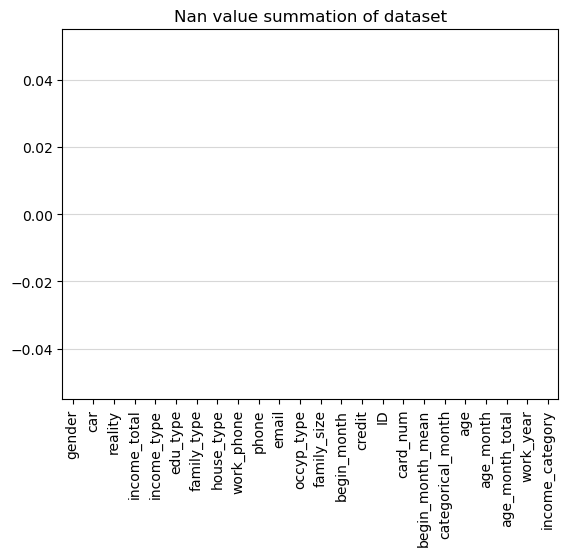

In [25]:
nan_value_count(user_list)

In [26]:
# corr 시각화
def corr_heatmap(dataset):
    """[상관관계 그래프]

    Args:
        dataset ([DataFrame]): [데이터프래임을 입력해주세요]
    """
    mask_ut=np.triu(np.ones(dataset.corr().shape)).astype(np.bool) 
    sns.heatmap(dataset.corr(), annot = True, cmap = 'RdYlBu_r', cbar_kws={"shrink": .5}, 
                annot_kws={"size": 6}, linewidths=.5, mask=mask_ut)
    plt.figure(figsize=(40,40))
    plt.show()

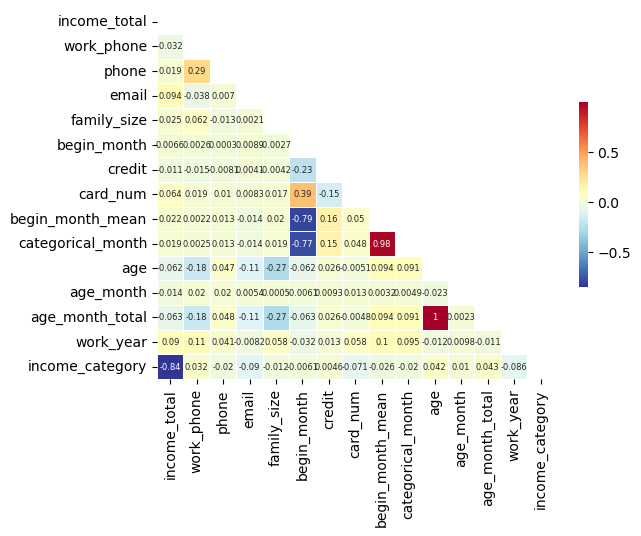

<Figure size 4000x4000 with 0 Axes>

In [27]:
corr_heatmap(user_list)

In [28]:
def col_corr_list(dataset, col_name):
    """[데이터 프레임 내 컬럼의 상관 관계를 보여주는 plot입니다.]

    Args:
        dataset ([DataFrame]): [데이터프레임을 입력해주세요]
        col_name ([column]): [데이터 내의 컬럼 이름을 입력해주세요]
    """
    # credit correlation을 크기별로 정렬하고 인덱스를 뽑습니다.
    y_label = dataset.corr()[[col_name]].sort_values(by=col_name,ascending=False).index.tolist()
    
    fig, ax = plt.subplots(figsize=(3, 6))
    sns.heatmap(dataset.corr()[[col_name]].sort_values(by=col_name,ascending=False), 
                vmin = -1, vmax = 1, annot=True, cmap="RdYlBu_r")
    ax.set_title('Correlation Heatmap with {}'.format(col_name), pad = 12)
    ax.set_yticklabels(y_label, rotation=0)
    plt.show()

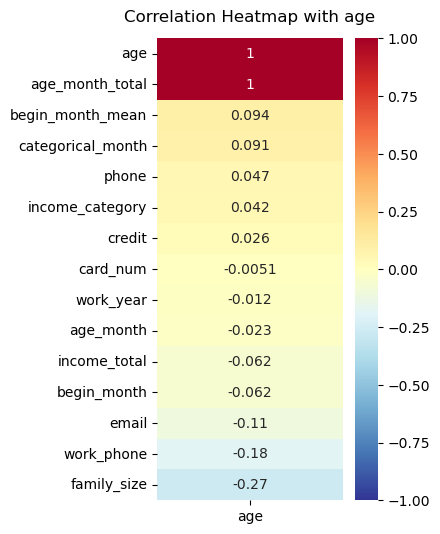

In [29]:
col_corr_list(user_list, 'age')

In [30]:
def col_type(dataset):
    """[columne의 type별 분류를 실행해줍니다.]
    
        dataset ([DataFrame]): [데이터 프레임 명을 입력해 주세요]
        
        column의 datatype이 object인 것과 numeric인 것을 출력해줍니다.
    """
    object_list = []
    numeric_list = []
    for i in range(dataset.columns.nunique()):
        if (np.dtype(dataset[dataset.columns[i]]) == object) == True :
            object_list.append(dataset.columns[i])
        else:
            numeric_list.append(dataset.columns[i])
    
    print("object type인 column의 리스트 \n", object_list, '\n')
    print('numeric type인 column의 리스트 \n', numeric_list)
    

In [31]:
col_type(user_list)

object type인 column의 리스트 
 ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'ID'] 

numeric type인 column의 리스트 
 ['income_total', 'work_phone', 'phone', 'email', 'family_size', 'begin_month', 'credit', 'card_num', 'begin_month_mean', 'categorical_month', 'age', 'age_month', 'age_month_total', 'work_year', 'income_category']


In [32]:
def boxplot_user_list(dataset, x_col, y_col, hue_name):
    """[data는 user_list를 대상으로 시행합니다. 가로방향으로 출력되므로 x,y축 컬럼 설정에 주의해주세요]

    Args:
        dataset ([DataFrame]): [데이터프레임을 입력해주세요]
        x_col ([column_numeric type]): [x축에 올 칼럼으로 numeric 타입을 입력하세요]
        y_col ([column_object type]): [y축에 올 칼럼으로 object 타입을 입력해주세요]
        hue_name ([column_object type]): [hue 옵션으로 카테고리별 분류를 시켜줍니다.]
    """
    sns.boxplot(x =x_col, y=y_col, hue=hue_name, data=dataset)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title=hue_name)
    plt.title('boxplot : each {} of {} (+ {} split)'.format(x_col,y_col,hue_name))
    plt.grid(axis='y', alpha = .5)
    plt.show()

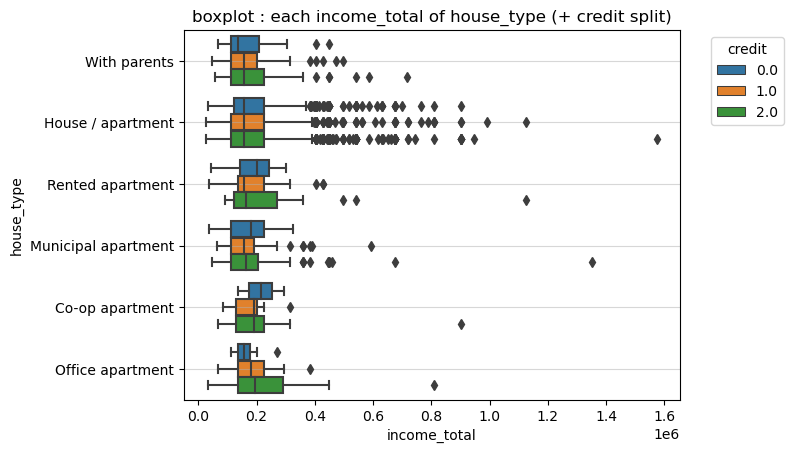

In [33]:
boxplot_user_list(user_list,'income_total', 'house_type','credit')

In [34]:
def count_plot(dataset, feature_1, hue_name):
    """[summary]

    Args:
        dataset ([DataFrame]): [데이터프레임 이름을 입력해주세요]
        feature_1 ([object type column]): [object_type인 칼럼을 입력해주세요]
        hue_name ([object type column]): [카테고리별 분류하기 위한 칼럼입니다]
    """
    sns.countplot(y=feature_1, data=dataset, hue=hue_name)
    plt.title('count of {} (category : {})'.format(feature_1, hue_name))
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='{}'.format(hue_name))
    plt.grid(axis='x', alpha = .5)
    plt.show()

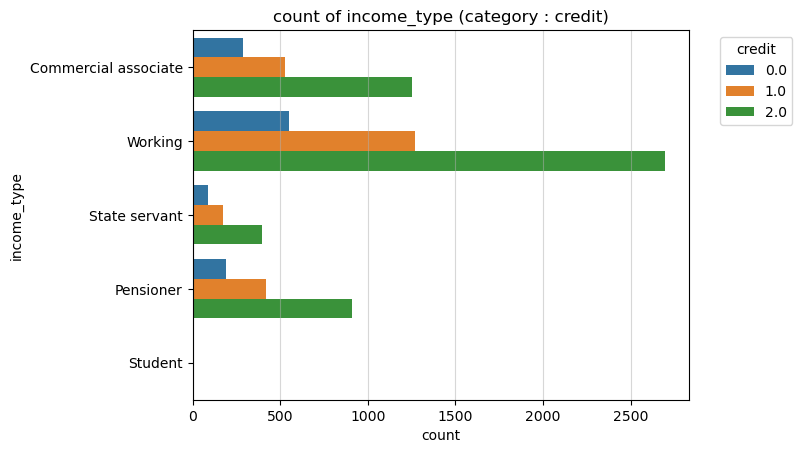

In [35]:
count_plot(user_list, 'income_type', 'credit')

In [36]:
def bar_plot(dataset, x_col, y_col, hue_name):
    """[summary]

    Args:
        dataset ([DataFrame]): [데이터프레임 이름을 입력해주세요]
        x_col ([numeric_type column]): [x축에 올 컬럼으로 평균치를 보여줍니다.]
        y_col ([object_type column]): [y축에 올 컬럼으로 카테고리별 평균으로 보여줍니다.]
        hue_name ([object_type column]): [카테고리별로 분류해줍니다]
    """
    sns.barplot(x=x_col, y=y_col, data= dataset, hue = hue_name)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title='{}'.format(hue_name))
    plt.title('each {} of {} mean (category : {})'.format(y_col, x_col, hue_name))
    plt.gcf().text(0.3, -.05, 'black line : confidence level 95%', fontsize=10)
    plt.grid(axis='x', alpha = .5)
    plt.show()

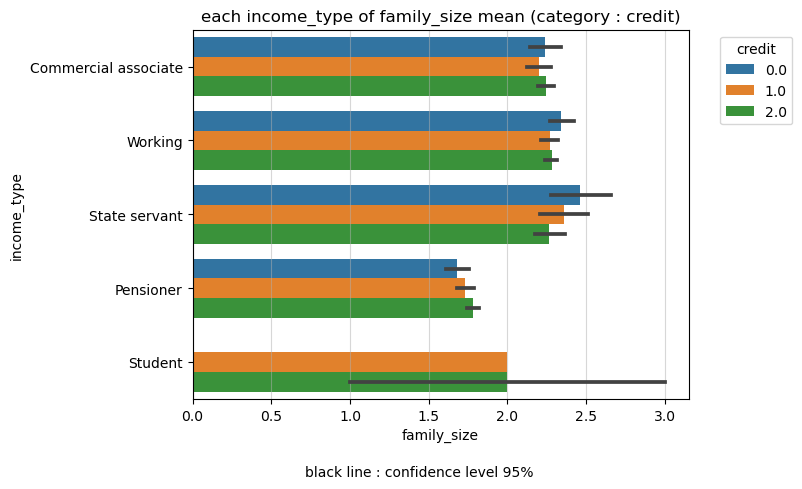

In [37]:
bar_plot(user_list, 'family_size', 'income_type', 'credit')

In [38]:
def num_plot_occpy_nan(feature_1, feature_2):
    """ [dataset]
    
        표시되는 그룹은 occpy_type == Nan으로 표시된 사람들을 대상으로 그룹화한 것입니다.
        
        [parameter]
        feature_1 ([object type]): [y축에 표시할 objec입니다. 직업을 제외한 칼럼을 입력하세요]
        feature_2 ([numeric type]): [x축에 표시될 object별 feature_2의 mean값입니다.]
        red_line : feature_2의 전체 평균입니다.
    """
    grouped_occpy = user_list[user_list['occyp_type']=='Nan'].groupby(user_list[feature_1])
    grouped_occpy[feature_2].mean().plot(kind='barh')
    plt.axvline(user_list[user_list['occyp_type']=='Nan'][feature_2].mean(), 
                color= 'r', linestyle = ':',  label = '{} mean of all {}'.format(feature_2, feature_1))
    plt.xlabel('{} mean'.format(feature_2))
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = feature_2)
    plt.grid(axis='x', alpha = .5)
    plt.title('each {} of {} mean'.format(feature_1, feature_2))
    plt.show()

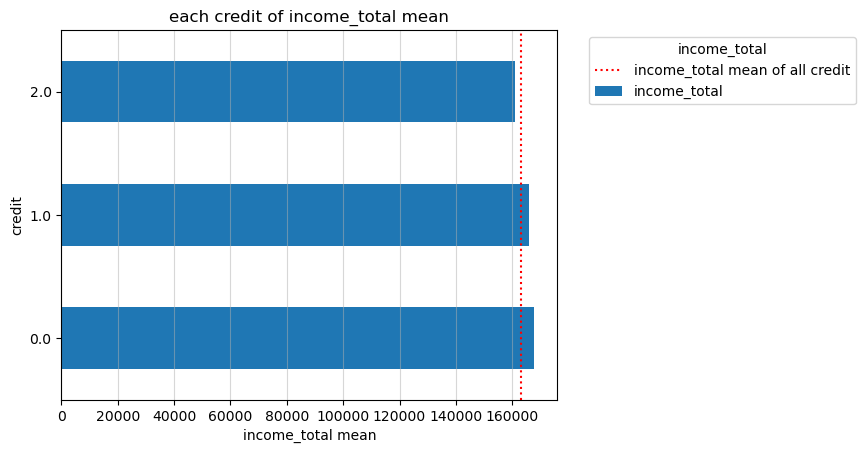

In [39]:
num_plot_occpy_nan('credit', 'income_total')

In [40]:
def plot_occpy_nan(feature_1st, feature_2nd):
    """[occpy_type이 Nan인 사람 대상입니다. feature_1st 각각의 object에 feature_2nd의 countplot으로 표시된 그래프를 나타냅니다.]

    Args:
        feature_1st ([object_type]): [dataset의 columns 중 object type 만 넣어주세요 (직업도 제외)]
        feature_2nd ([object_type]): [dataset의 columns 중 object type 만 넣어주세요 (직업도 제외)]
    """
    subset = user_list['occyp_type'].fillna('Nan')
    subset = user_list[user_list['occyp_type'] == 'Nan']
    sns.countplot(y=feature_1st, data = subset, hue = feature_2nd)
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', title = feature_2nd)
    plt.title('each {} of {} : count plot'.format(feature_1st, feature_2nd))
    plt.grid(axis='x', alpha = .5)
    plt.show()

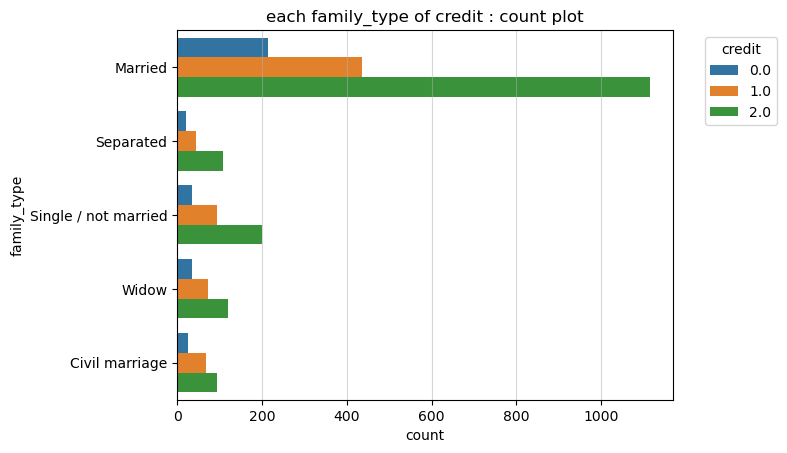

In [41]:
plot_occpy_nan('family_type', 'credit')